In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error as mae 

In [2]:
#Load (unpickle) the dictionary of DataFrames from the file
with open('../Data/test_train_datasets.pkl', 'rb') as f:
    sample_dfs = pickle.load(f)  # 'rb' for reading in binary mode

sample_dfs.keys()

dict_keys(['metro_samp_1', 'metro_samp_1_train', 'metro_samp_1_test', 'metro_samp_2', 'metro_samp_2_train', 'metro_samp_2_test', 'metro_samp_3', 'metro_samp_3_train', 'metro_samp_3_test', 'metro_samp_val', 'metro_samp_val_train', 'metro_samp_val_test', 'metro_samp_1_train_normalized', 'metro_samp_1_test_normalized', 'metro_samp_2_train_normalized', 'metro_samp_2_test_normalized', 'metro_samp_3_train_normalized', 'metro_samp_3_test_normalized', 'metro_samp_val_train_normalized', 'metro_samp_val_test_normalized'])

In [3]:
y_var = 'frwd01_mon_metro_hvi_pct_chg'

In [4]:
train_df = sample_dfs['metro_samp_val_train_normalized'].dropna(subset=y_var)                      
test_df = sample_dfs['metro_samp_val_test_normalized'].dropna(subset=y_var)

In [5]:
X_cols = [col for col in sample_dfs['metro_samp_val_train_normalized'].columns if "frwd" not in col]
y_cols = [col for col in sample_dfs['metro_samp_val_train_normalized'].columns if "frwd" in col]

In [7]:
X_cols_2 = (X_cols[:7]+
            X_cols[X_cols.index('metro_for_sale_inventory_normalized'):
                   X_cols.index('prev01_mon_metro_for_sale_inventory')]+
            X_cols[X_cols.index('prev01_mon_metro_for_sale_inventory_pct_chg'):
                   X_cols.index('prev01_mon_state_job_openings_szn_adjd_pct_chg')]+
            X_cols[X_cols.index('prev02_mon_metro_for_sale_inventory_pct_chg'):
                   X_cols.index('prev02_mon_state_job_openings_szn_adjd_pct_chg')]+
            X_cols[X_cols.index('prev03_mon_metro_for_sale_inventory_pct_chg'):
                   X_cols.index('prev03_mon_state_job_openings_szn_adjd_pct_chg')]+
            X_cols[X_cols.index('prev06_mon_metro_for_sale_inventory_pct_chg'):
                   X_cols.index('prev06_mon_state_job_openings_szn_adjd_pct_chg')])

In [8]:
#create class to generate key statistics from confusion matrix
class confusion_matrix_class:
    def __init__(self, cm):
        self.cm = cm
        self.tp = cm[0,0]
        self.fp = cm[0,1]
        self.fn = cm[1,0]
        self.tn = cm[1,1]
        self.accuracy = ((self.tp+self.tn)/(self.tp+self.fp+self.fn+self.tn))
        self.precision = (self.tp/(self.tp+self.fp))
        self.recall = (self.tp/(self.tp+self.fn))
        self.F1 = (2*self.precision*self.recall)/(self.precision+self.recall)
        self.specificity = (self.tn/(self.tn+self.fp))

In [9]:
def RF_model(train_df, X_vars, y_var, n_est, min_samples_leaf, max_features, n_jobs=-1, seed=42):
    #identify and drop columns with over 75% of data missing in training dataset
    drop_cols = train_df.isna().sum().divide(len(train_df)).sort_values(ascending=False).reset_index().rename(columns={'index':'col',0:'missing'})
    #print(drop_cols.to_string())
    drop_cols['drop'] = np.where(drop_cols['missing'] > .70, "drop", "keep")
    drop_cols = list(drop_cols[drop_cols['drop'] == 'drop'].col)
    train_df = train_df.drop(columns=drop_cols)
    X_cols_rf = [col for col in X_vars if col not in drop_cols]

    #define training set
    train_df = train_df.replace(np.inf, np.nan)
    train_df = train_df.dropna()
    X = train_df[X_cols_rf[7:]]
    y = train_df[y_var]

    #create estimator
    rf_model = RandomForestRegressor(n_estimators=n_est, 
                                     min_samples_leaf=min_samples_leaf,
                                     max_features=max_features,
                                     n_jobs=n_jobs, 
                                     random_state=seed)
    #train estimator
    rf_model.fit(X, y)
    train_df['y_pred_pct'] = rf_model.predict(X)
    train_df['y_true'] = np.where(train_df[y_var] >= 0, 1, 0)
    train_df['y_pred'] = np.where(train_df['y_pred_pct'] >= 0, 1, 0)
    
    return(rf_model, train_df, X_cols_rf, drop_cols)

In [10]:
rf_model, trained_df, X_cols_rf, drop_cols = RF_model(train_df, X_cols_2, y_var, 48, 32, None)

In [11]:
tested_df = test_df.replace(np.inf, np.nan)
tested_df = tested_df.drop(columns=drop_cols)
tested_df = tested_df.dropna()

X_test = tested_df[X_cols_rf[7:]]
y_test = tested_df[y_var]

tested_df['y_pred_pct'] = rf_model.predict(X_test)
tested_df['y_true'] = np.where(tested_df[y_var] >= 0, 1, 0)
tested_df['y_pred'] = np.where(tested_df['y_pred_pct'] >= 0, 1, 0)

tested_df['y_pred_hvi_amt'] = (tested_df['y_pred_pct']+1) * tested_df['metro_hvi'] 


error = mae(tested_df[y_var], tested_df['y_pred_pct'])
print("Mae:",error)

cm = confusion_matrix_class(confusion_matrix(tested_df['y_true'], tested_df['y_pred']))
vars(cm)

Mae: 0.002575685077711064


{'cm': array([[1723,  887],
        [ 104, 3876]], dtype=int64),
 'tp': 1723,
 'fp': 887,
 'fn': 104,
 'tn': 3876,
 'accuracy': 0.8496206373292868,
 'precision': 0.6601532567049808,
 'recall': 0.9430760810071155,
 'F1': 0.776650890241154,
 'specificity': 0.8137728322485829}

In [12]:
tested_df[['metro_name','period',y_var,'y_pred_pct','frwd01_mon_metro_hvi','y_pred_hvi_amt']]

,metro_name,period,frwd01_mon_metro_hvi_pct_chg,y_pred_pct,frwd01_mon_metro_hvi,y_pred_hvi_amt
18,"Aberdeen, WA",2022-07-31,-0.008030,0.000775,3.341319e+05,3.370979e+05
19,"Aberdeen, WA",2022-08-31,-0.014267,-0.005518,3.293649e+05,3.322883e+05
20,"Aberdeen, WA",2022-09-30,-0.013097,-0.005523,3.250513e+05,3.275459e+05
21,"Aberdeen, WA",2022-10-31,-0.010365,-0.005523,3.216821e+05,3.232562e+05
22,"Aberdeen, WA",2022-11-30,-0.009750,-0.005661,3.185456e+05,3.198611e+05
...,...,...,...,...,...,...
15993,"Urban Honolulu, HI",2023-04-30,0.004686,0.005089,1.075518e+06,1.075950e+06
15994,"Urban Honolulu, HI",2023-05-31,0.005138,0.006688,1.081044e+06,1.082710e+06
15995,"Urban Honolulu, HI",2023-06-30,0.002930,0.005794,1.084211e+06,1.087307e+06
15996,"Urban Honolulu, HI",2023-07-31,0.002692,0.004256,1.087129e+06,1.088826e+06


In [13]:
print(len(tested_df.metro_id.unique()),"unique metro areas predicted")

471 unique metro areas predicted


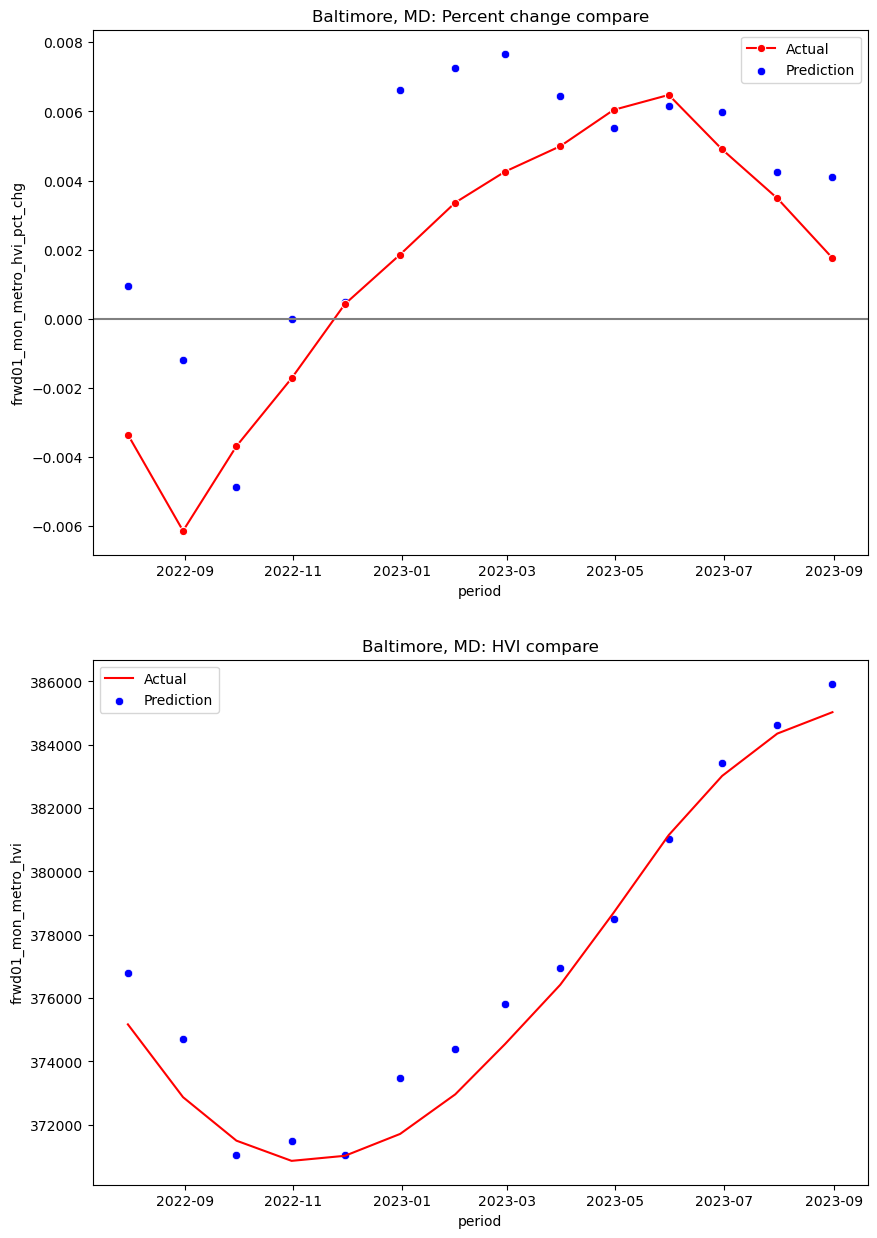

In [35]:
metro = 'Baltimore, MD'
fig, ax = plt.subplots(2,1, figsize=(10,15))

sns.lineplot(data=tested_df[tested_df.metro_name==metro], x='period', y='frwd01_mon_metro_hvi', color='red', ax=ax[1], label='Actual')
sns.scatterplot(data=tested_df[tested_df.metro_name==metro], x='period', y='y_pred_hvi_amt', color='blue', ax=ax[1], label='Prediction')
ax[1].set_title(metro+": HVI compare")

sns.lineplot(data=tested_df[tested_df.metro_name==metro], x='period', y=y_var, color='red', ax=ax[0], label='Actual', marker='o')
sns.scatterplot(data=tested_df[tested_df.metro_name==metro], x='period', y='y_pred_pct', color='blue', ax=ax[0], label='Prediction')
ax[0].axhline(y=0, c="gray")
ax[0].set_title(metro+": Percent change compare")

plt.show()

In [32]:
random.seed(42)
metros_samp = random.sample(list(tested_df.metro_name.unique()),k=60)
samp_count = len(metros_samp)

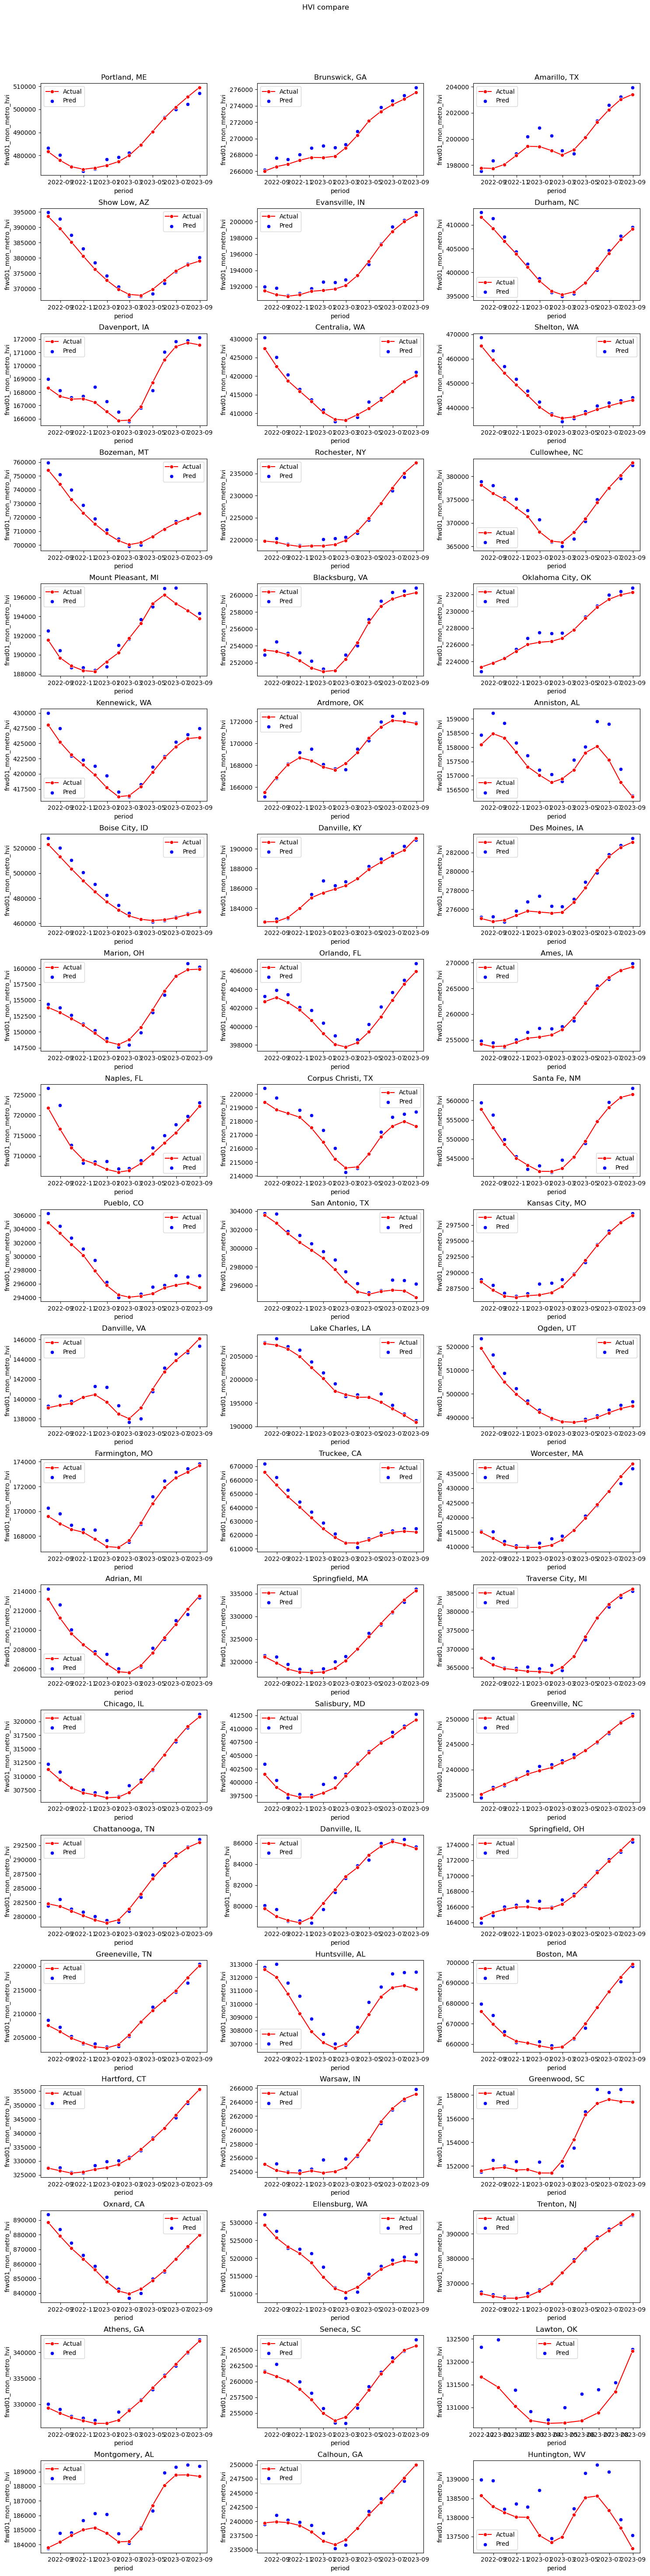

In [36]:
fig, ax = plt.subplots(int(samp_count/3), 3, figsize=(15,60))

for i, metro in enumerate(metros_samp):
    df = tested_df[tested_df.metro_name==metro]
    ax_loc = ax[i // 3, i % 3]
    
    sns.lineplot(data=df, x='period', y='frwd01_mon_metro_hvi', color='red', ax=ax_loc, label='Actual', legend=True, marker='o')
    sns.scatterplot(data=df, x='period', y='y_pred_hvi_amt', color='blue', ax=ax_loc, label='Pred', legend=True)

    ax_loc.set_title(metro)
    
plt.subplots_adjust(hspace=.8, wspace=0.5)
fig.suptitle('HVI compare')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

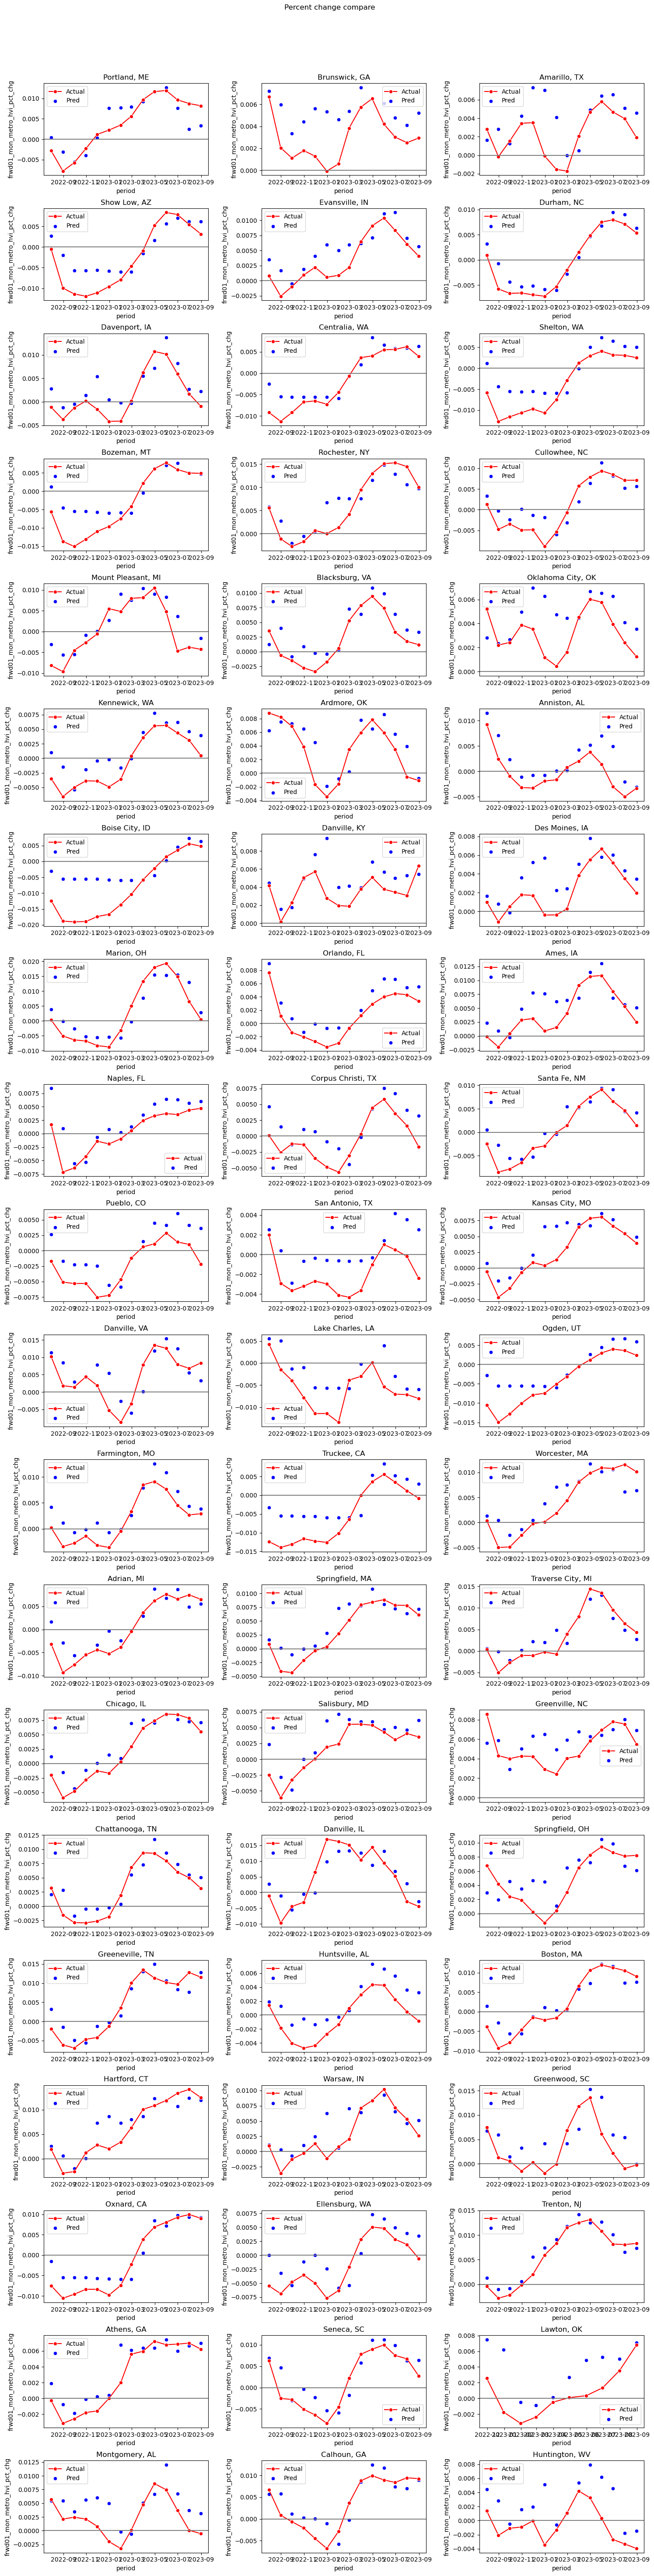

In [37]:
fig, ax = plt.subplots(int(samp_count/3), 3, figsize=(15,60))

for i, metro in enumerate(metros_samp):
    df = tested_df[tested_df.metro_name==metro]
    ax_loc = ax[i // 3, i % 3]
    
    sns.lineplot(data=df, x='period', y=y_var, color='red', ax=ax_loc, label='Actual', legend=True, marker='o')
    sns.scatterplot(data=df, x='period', y='y_pred_pct', color='blue', ax=ax_loc, label='Pred', legend=True)
    ax_loc.axhline(y=0, c="gray")
    ax_loc.set_title(metro)
    
plt.subplots_adjust(hspace=.8, wspace=0.5)
fig.suptitle('Percent change compare')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()